In [12]:
import ray

In [13]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2025-09-04 13:07:26,530	INFO worker.py:1951 -- Started a local Ray instance.


Python version:,3.12.3
Ray version:,2.49.1


In [14]:
ray.cluster_resources()

{'memory': 7167079629.0,
 'node:__internal_head__': 1.0,
 'object_store_memory': 3071605555.0,
 'node:172.16.218.42': 1.0,
 'CPU': 12.0}

In [15]:
import pandas as pd

In [16]:
# Data Ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df=pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [19]:
# split dataset
test_size=0.2
train_df,val_df=train_test_split(df,test_size=test_size,random_state=1234)

In [20]:
train_df.tag.value_counts()

tag
natural-language-processing    253
computer-vision                221
other                           87
mlops                           50
Name: count, dtype: int64

In [22]:
val_df.tag.value_counts() * int((1-test_size)/test_size)

tag
computer-vision                256
natural-language-processing    228
other                           76
mlops                           52
Name: count, dtype: int64

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [24]:
all_tags=Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

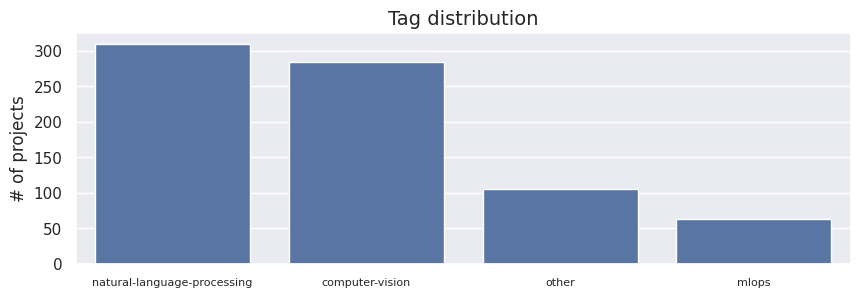

In [25]:
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

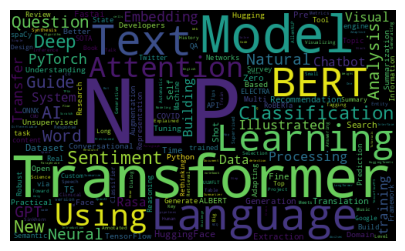

In [28]:
# Most frequent tokens for each tag
tag = "natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag == tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS,
    background_color="black",
    collocations=False,
    width=500,
    height=300,
).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

In [29]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [37]:
df["text"]=df.title+" "+df.description

In [32]:
nltk.download("stopwords")
STOPWORDS=stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bs00927/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [40]:
original_df=df.copy()
df.text=df.text.apply(clean_text)
print(f"{original_df.text[0]}\n{df.text[0]}")

comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [41]:
# dataframe cleanup
df=df.drop(columns=["id", "created_on", "title", "description"],errors="ignore")
df=df.dropna(subset=["tag"])#drop null tags 
df=df[["text","tag"]]# re-arrange columns
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [ ]:
# Converting tags into numbers for LLM.
ags=train_df.tag.unique().tolist()
num_classes=len(tags)
class_to_index={tag:i for i,tag in enumerate(tags)}
class_to_index

In [45]:
df["tag"]=df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,0
3,awesome monte carlo tree search curated list m...,0
4,attentionwalk pytorch implementation watch ste...,0


In [56]:
def decode(indices,index_to_class):
    return [index_to_class[i] for i in indices]

In [57]:
index_to_class={v:k for k,v in class_to_index.items()}
decode(df.head()["tag"].values,index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

In [60]:
import numpy as np
from transformers import BertTokenizer

In [76]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained(
        "allenai/scibert_scivocab_uncased", return_dict=False
    )
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], mask=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [81]:
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

In [82]:
def preprocess(df,class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(
        columns=["id", "created_on", "title", "description"], errors="ignore"
    )  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [ ]:
preprocess(train_df,class_to_index)

{'ids': array([[  102, 22231,  5803, ...,     0,     0,     0],
        [  102,  3254,  7201, ...,     0,     0,     0],
        [  102, 10693,  1777, ...,     0,     0,     0],
        ...,
        [  102, 21856,  1461, ...,     0,     0,     0],
        [  102, 27458,  1135, ...,     0,     0,     0],
        [  102,   553,  7631, ...,     0,     0,     0]], shape=(611, 40)),
 'mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], shape=(611, 40)),
 'targets': array([0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 3,
        2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 3, 1, 2, 2, 3, 0, 1, 1, 2, 2, 0,
        1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 3, 2, 2, 2, 0, 2,
        1, 1, 2, 1, 2, 1, 0, 0, 2, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 1, 1, 2,
        3, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 0, 3, 1, 1, 0,


: 